# **Data Project**

<br>

# Setup

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

%load_ext autoreload
%autoreload 2

from project_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<br>

# Read and clean data

In [2]:
# read data set
ets = clean_ets(pd.read_csv('ETS_Database_v49_Jul22.csv', sep='\t'))

# seperate into categories, using copies to prevent unintended changes
allocations = ets.loc[ets['category'].str.startswith('1.')].copy()
emissions = ets.loc[ets['category'].str.startswith('2.')].copy()

display(ets)

,country,country_code,category,sector,value,year
0,Austria,AT,1.1.1 Free allocation to existing entities (Ar...,32 Manufacture of ceramics,481340.0,2011
1,Austria,AT,1.1.1 Free allocation to existing entities (Ar...,32 Manufacture of ceramics,478462.0,2012
2,Austria,AT,1.1.2 Free allocation from the new entrants re...,32 Manufacture of ceramics,0.0,2017
3,Austria,AT,1.1.2 Free allocation from the new entrants re...,32 Manufacture of ceramics,0.0,2018
4,Austria,AT,1.1.2 Free allocation from the new entrants re...,32 Manufacture of ceramics,0.0,2021
...,...,...,...,...,...,...
33049,Slovenia,SI,2.1 EU-ETS Verified Emission,24 Production of pig iron or steel,217488.0,2016
33050,Slovenia,SI,2.1 EU-ETS Verified Emission,24 Production of pig iron or steel,222518.0,2019
33051,Slovenia,SI,4.2 Surrendered certified emission reductions ...,24 Production of pig iron or steel,0.0,2011
33052,Slovenia,SI,4.2 Surrendered certified emission reductions ...,24 Production of pig iron or steel,0.0,2012


<br>

# Explore each data set

### Emissions

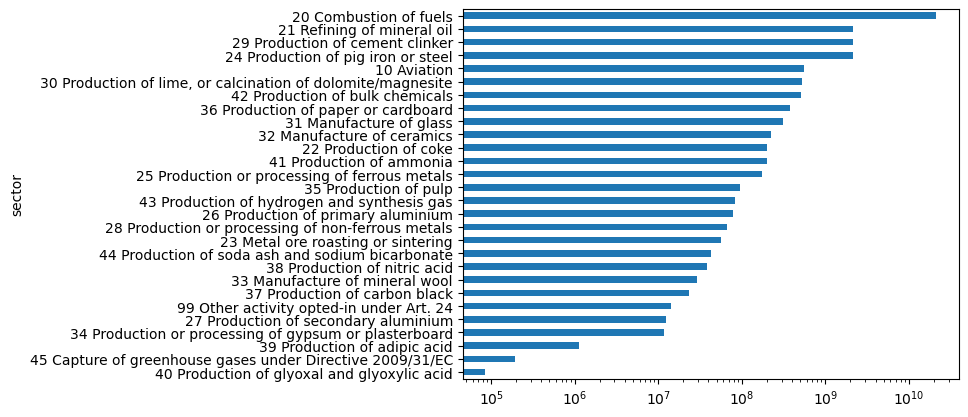

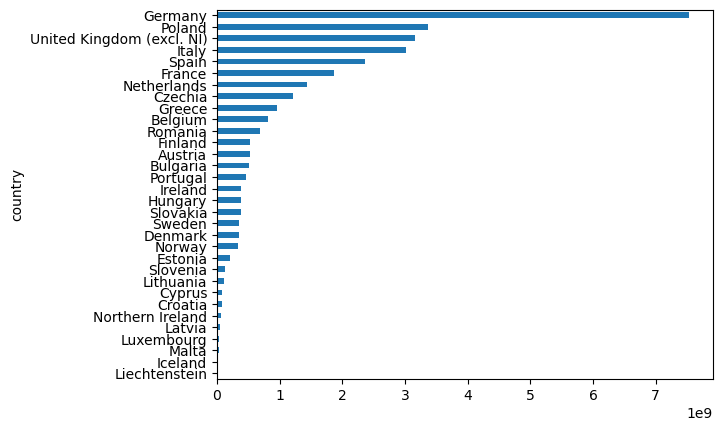

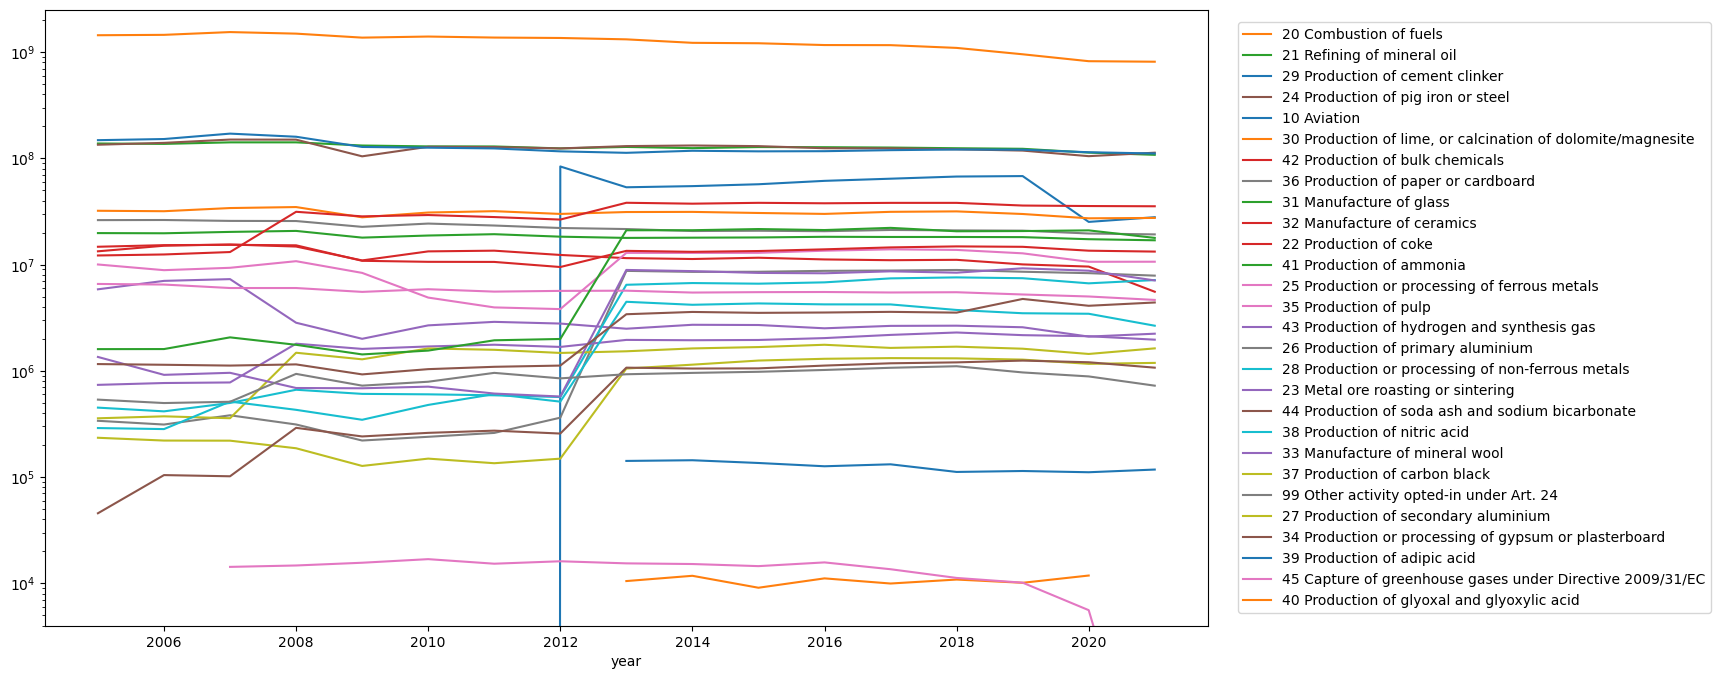

In [74]:
# by sector
emsh_by_sector = emissions.groupby('sector')['value'].apply('sum')
emsh_by_sector.sort_values(inplace=True)
plt.figure(); emsh_by_sector.plot(kind='barh', logx=True)

# by country
emsh_by_country = emissions.groupby('country')['value'].apply('sum')
emsh_by_country.sort_values(inplace=True)
plt.figure(); emsh_by_country.plot(kind='barh')

# by sector over time
emsh_by_sector_t = emissions.groupby(['sector', 'year'])['value'].apply('sum').reset_index(); 
fig, ax = plt.subplots(figsize=(15,8))
for name, sector in emsh_by_sector_t.groupby('sector'): sector.plot(ax=ax, x='year', y='value', label=name, logy=True, ylim=(10**3.6, 10**9.4))
sort_legend(ax, key=lambda label: emsh_by_sector[label], reverse=True, bbox_to_anchor=(1.02,0.5), loc='center left')

<br>

### Allocations

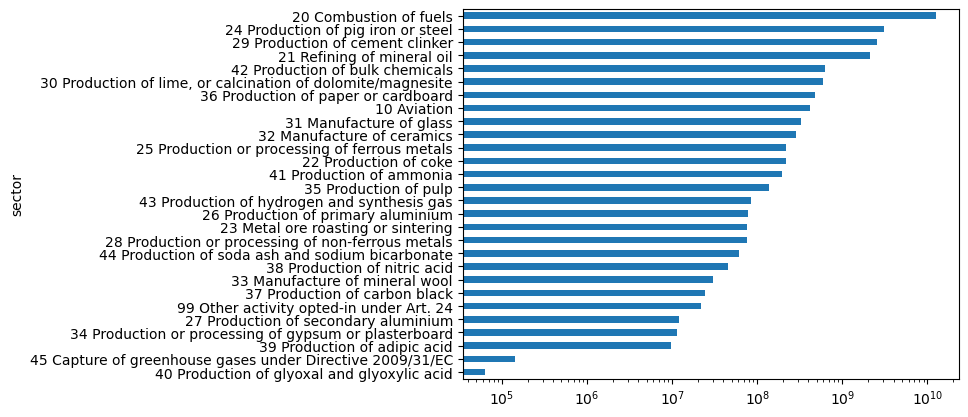

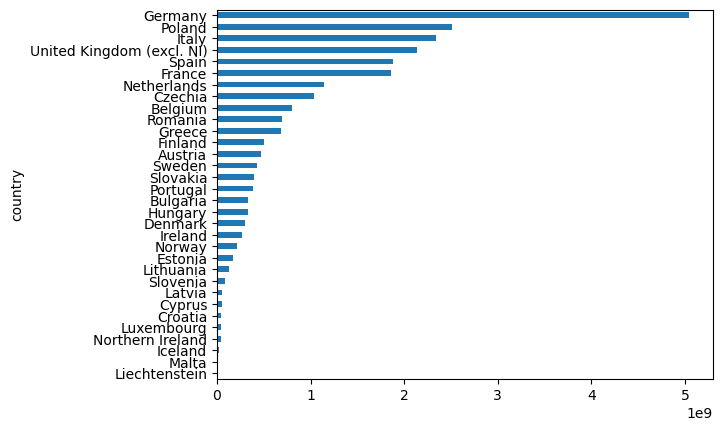

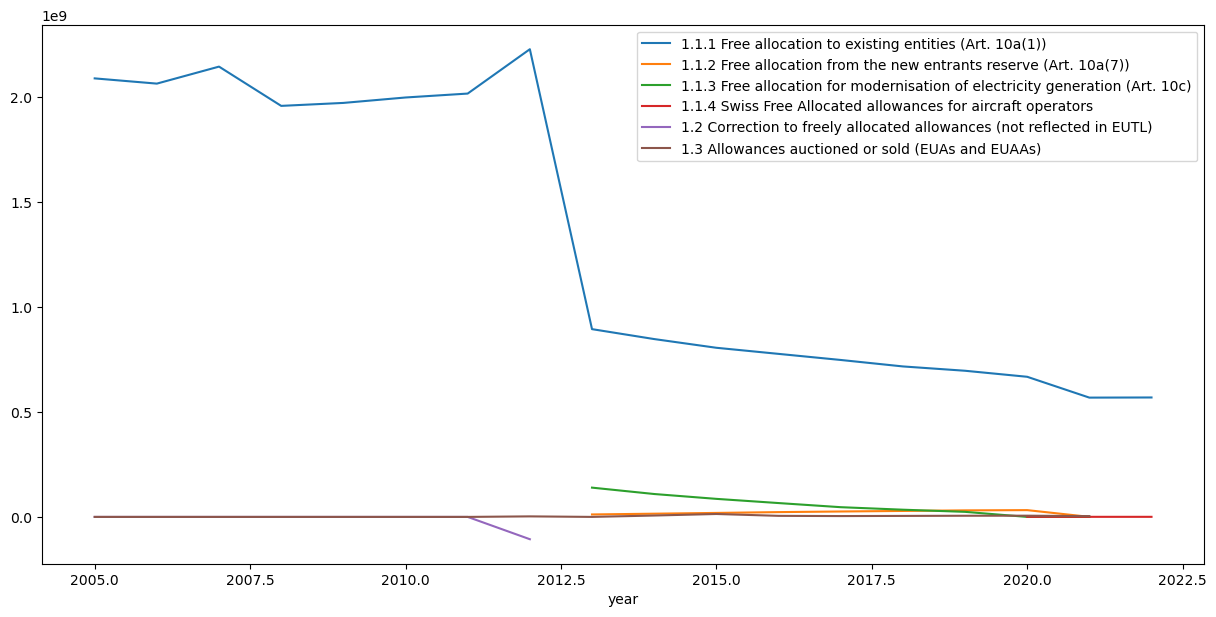

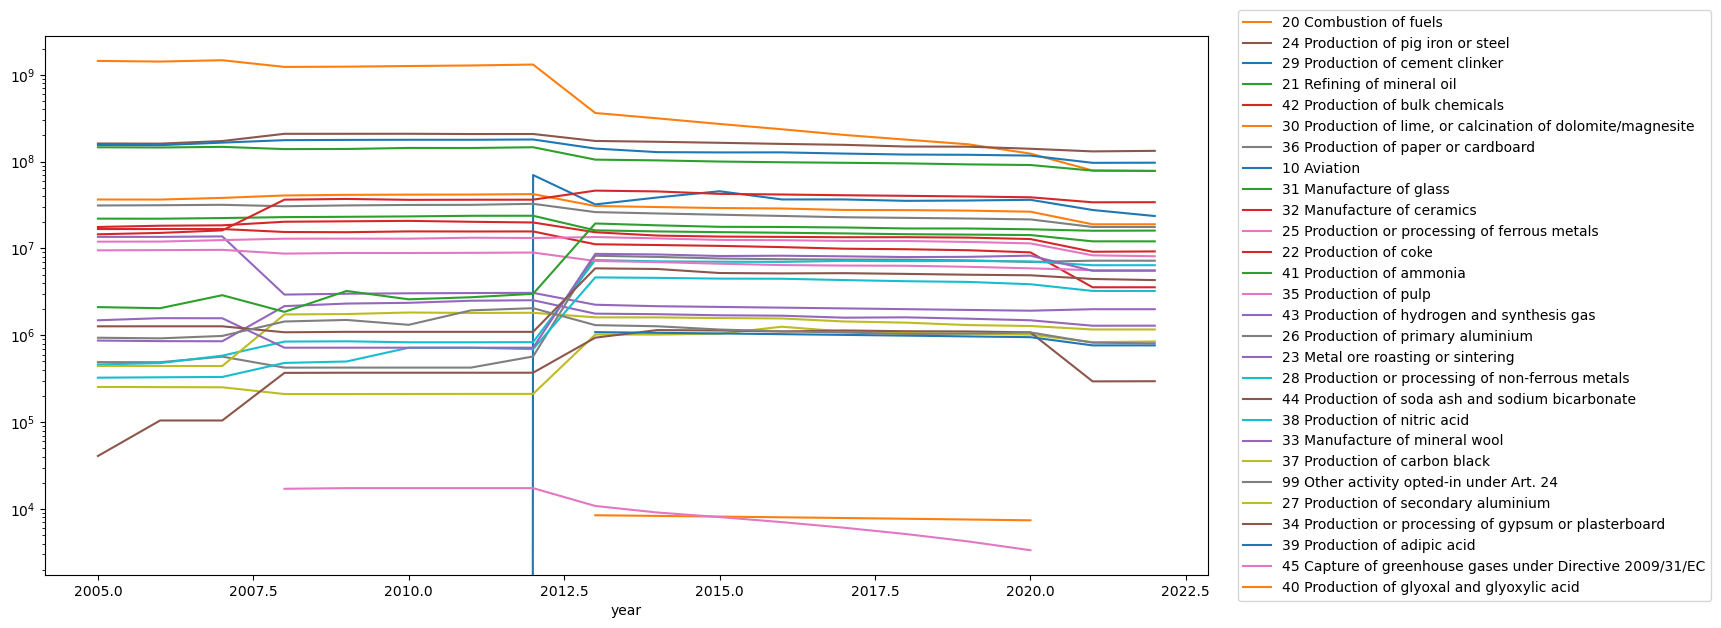

In [146]:
# by sector
aloc_by_sector = allocations.groupby('sector')['value'].apply('sum')
aloc_by_sector.sort_values(inplace=True)
plt.figure(); aloc_by_sector.plot(kind='barh', logx=True)

# by country
aloc_by_country = allocations.groupby('country')['value'].apply('sum')
aloc_by_country.sort_values(inplace=True)
plt.figure(); aloc_by_country.plot(kind='barh')

# by category over time
aloc_by_category_t = allocations.groupby(['category', 'year'])['value'].apply('sum').reset_index(); 
fig, ax = plt.subplots(figsize=(15,7))
for name, category in aloc_by_category_t.groupby('category'): category.plot(ax=ax, x='year', y='value', label=name)

# by sector over time
aloc_by_sector_t = allocations.groupby(['sector', 'year'])['value'].apply('sum').reset_index(); 
fig, ax = plt.subplots(figsize=(15,7))
for name, sector in aloc_by_sector_t.groupby('sector'): sector.plot(ax=ax, x='year', y='value', label=name, logy=True)
sort_legend(ax, key=lambda label: aloc_by_sector[label], reverse=True, bbox_to_anchor=(1.02,0.5), loc='center left')

<br><br>

# Analysis

### Emissions by country over time, indexed

In [115]:
emsh_by_country_t = emissions.groupby(['country', 'year'])['value'].apply('sum').reset_index()

In [120]:
# identify index: second nonzero entry for country
countries = emissions['country'].unique()
years = emissions['year'].unique(); years.sort()
indexes = {}

for country in countries:
    country_data = emsh_by_country_t.loc[emsh_by_country_t['country']==country]
    counter = 0

    for year in years:
        value = country_data.loc[country_data['year'] == year]['value']
        if value.empty or value.item()==0: continue
        counter += 1
        if counter >= 2: break

    indexes[country] = value.item()


# create new column with indexed values
def relative_to_index(df): return df['value'] / indexes[df.name]
emsh_by_country_t['value_indexed'] = emsh_by_country_t.groupby('country', group_keys=False).apply(relative_to_index)

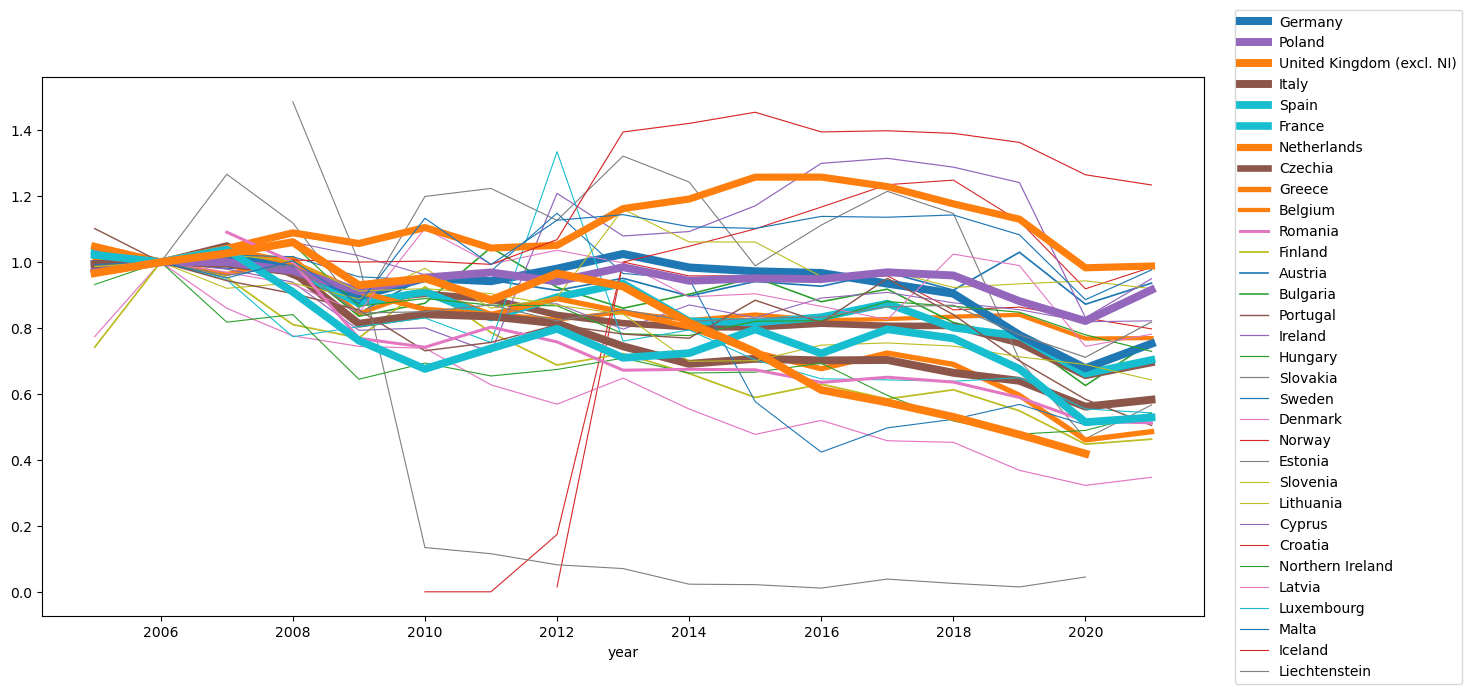

In [145]:
# create plot, line thickness captures country emissions
country_weights = stretch_series(emsh_by_country, pow=0.05, span=5, lb=0.8)
fig, ax = plt.subplots(figsize=(15,7))
for name, country in emsh_by_country_t.groupby('country'): country.plot(ax=ax, x='year', y='value_indexed', label=name, lw=country_weights[name])
sort_legend(ax, key=lambda label: emsh_by_country[label], reverse=True, bbox_to_anchor=(1.02,0.5), loc='center left')

<br>

### Change in emissions against change in allocations by sector

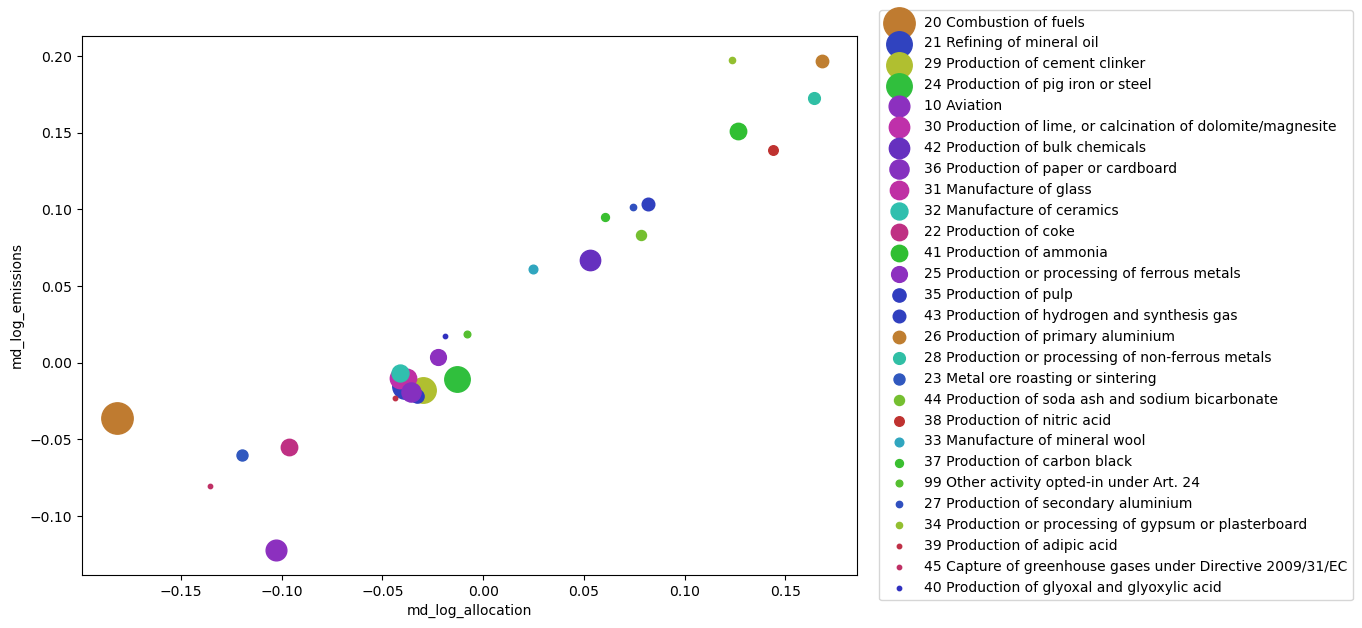

In [217]:
# drop zeros and merge
emsh_by_sector_t_0 = emsh_by_sector_t.loc[emsh_by_sector_t['value']!=0]
aloc_by_sector_t_0 = aloc_by_sector_t.loc[aloc_by_sector_t['value']!=0]
sector_emsh_aloc = pd.merge(emsh_by_sector_t_0, aloc_by_sector_t_0, on=['year', 'sector'], how='inner', suffixes=('_emissions', '_allocation'))

# take logs
sector_emsh_aloc['log_emissions'] = np.log(both['value_emissions'])
sector_emsh_aloc['log_allocation'] = np.log(both['value_allocation'])

# find change in logs
mean_diff = lambda x: np.mean(x.diff())
sector_changes = sector_emsh_aloc.groupby('sector').agg({'log_emissions':[mean_diff],'log_allocation':mean_diff})
sector_changes.columns = ['md_log_emissions', 'md_log_allocation']

# include emissions by sector
sector_changes['emissions'] = stretch_series(emsh_by_sector, pow=1, span=500, lb=10)

# plot
fig, ax = plt.subplots(figsize=(10,7))
for name, sector in sector_changes.groupby('sector'):
    sector.plot(ax=ax, kind='scatter', x='md_log_allocation', y='md_log_emissions', s='emissions', label=name, color=[[random_colour()]])
sort_legend(ax, key=lambda label: emsh_by_sector[label], reverse=True, bbox_to_anchor=(1.02,0.5), loc='center left')